# Abstract

The goal of this notebook is to understand how well the simulations are in the first place. In our example, we use a network where the policy was implemented in district 1-7. 

First thing:
1. Create a gdf with the links and the stats of the average case.
2. Create a gdf with the links and the stats of each random seed to the simulation. 


In [1]:
import pandas as pd
import processing_from_eqasim as pio
# Define the path to the CSV file
# file_path = '../../../data/test_data/sim_networks_d_1-7/'

# Read the CSV file into a DataFrame
# df = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the DataFrame
# df.head()

file_path = '../../data/test_data/sim_networks_d_1-7/'





import os
import glob
def get_subdirs(full_path: str):
    subdirs_pattern = os.path.join(full_path, '*')
    subdirs_list = list(set(glob.glob(subdirs_pattern)))
    subdirs_list.sort()
    return subdirs_list

basecase_subdir= get_subdirs(file_path)

In [10]:
import geopandas as gpd

# Define the relative path to the GeoJSON file
geojson_file_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'

# Read the GeoJSON file into a GeoDataFrame
gdf_basecase_mean = gpd.read_file(geojson_file_path)

# Display the first few rows of the GeoDataFrame
gdf_basecase_mean.head()

,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,isUrban,highway,storageCapacityUsedInQsim,edge_id,geometry
0,324663,1000258241,8880659948,20.037097,0.0,7999.2,1.0,"pt,rail,train",0.0,1,pt,0.032056,1000258241_8880659948,"LINESTRING (2.36296 48.88421, 2.36306 48.88437)"
1,261428,1000258241,8880659951,9.776025,0.0,7999.2,1.0,"pt,rail,train",0.0,1,pt,0.015640,1000258241_8880659951,"LINESTRING (2.36296 48.88421, 2.36291 48.88413)"
2,609662,1000258242,5646436942,8.333333,0.0,7999.2,1.0,"pt,rail,train",0.0,1,pt,NaN,1000258242_5646436942,"LINESTRING (2.36135 48.88099, 2.36136 48.88105)"
3,312238,1000258242,6556226602,26.739746,0.0,7999.2,1.0,"pt,rail,train",0.0,1,pt,0.042779,1000258242_6556226602,"LINESTRING (2.36135 48.88099, 2.36131 48.88075)"
4,69,1000258245,1000258255,36.086118,0.0,7999.2,1.0,"pt,rail,train",0.0,1,pt,0.057732,1000258245_1000258255,"LINESTRING (2.36170 48.88192, 2.36154 48.88161)"


In [3]:
random_seed_2_df_basecase_output_links = pio.create_dic_seed_2_output_links(subdir=basecase_subdir)
random_seed_2_df_basecase_eqasim_trips = pio.create_dic_seed_2_eqasim_trips(subdir=basecase_subdir)
basecase_output_links_gdfs = list(random_seed_2_df_basecase_output_links.values())
gdf_basecase_mean = pio.compute_average_or_median_geodataframe(geodataframes=basecase_output_links_gdfs, column_name="vol_car", is_mean=True)
gdf_basecase_mean = gdf_basecase_mean.rename(columns={"osm:way:highway": "highway"})

In [4]:
random_seed_2_df_basecase_eqasim_trips.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [14]:
# Ensure the links are sorted and matched before computing the car volume difference
gdf_seed_0_car_diff = gdf_basecase_mean.copy()

# Sort the DataFrames by 'link' to ensure they are aligned
gdf_seed_0_car_diff = gdf_seed_0_car_diff.sort_values(by='link').reset_index(drop=True)
random_seed_2_df_basecase_output_links['0'] = random_seed_2_df_basecase_output_links['0'].sort_values(by='link').reset_index(drop=True)

# Compute the car volume difference for each row
gdf_seed_0_car_diff['diff_car_volume'] = gdf_seed_0_car_diff['vol_car'] - random_seed_2_df_basecase_output_links['0']['vol_car']

# Display the first few rows of the new DataFrame
gdf_seed_0_car_diff.head()

# This we need to do for all random seeds. 


,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,isUrban,highway,storageCapacityUsedInQsim,edge_id,geometry,diff_car_volume
0,100315,24972409,24972408,16.181257,8.333333,480.0,1.0,"bus,car,car_passenger",6.627451,1,residential,NaN,24972409_24972408,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",1.627451
1,100316,5904976363,24983651,14.860209,8.333333,480.0,1.0,"bus,car,car_passenger,pt",9.607843,1,tertiary,NaN,5904976363_24983651,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",3.607843
2,100317,24983651,5904976363,14.860209,8.333333,960.0,2.0,"bus,car,car_passenger,pt",2.490196,1,tertiary,NaN,24983651_5904976363,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",1.490196
3,100321,664205947,24972376,22.264540,8.333333,960.0,2.0,"car,car_passenger",6.941176,1,residential,NaN,664205947_24972376,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",-0.058824
4,100324,24972376,24972375,64.853276,8.333333,480.0,1.0,"bus,car,car_passenger",7.607843,1,residential,NaN,24972376_24972375,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",-1.392157


In [15]:
gdf_seed_0_car_diff

,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,isUrban,highway,storageCapacityUsedInQsim,edge_id,geometry,diff_car_volume
0,100315,24972409,24972408,16.181257,8.333333,480.0,1.0,"bus,car,car_passenger",6.627451,1,residential,NaN,24972409_24972408,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",1.627451
1,100316,5904976363,24983651,14.860209,8.333333,480.0,1.0,"bus,car,car_passenger,pt",9.607843,1,tertiary,NaN,5904976363_24983651,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",3.607843
2,100317,24983651,5904976363,14.860209,8.333333,960.0,2.0,"bus,car,car_passenger,pt",2.490196,1,tertiary,NaN,24983651_5904976363,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",1.490196
3,100321,664205947,24972376,22.264540,8.333333,960.0,2.0,"car,car_passenger",6.941176,1,residential,NaN,664205947_24972376,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",-0.058824
4,100324,24972376,24972375,64.853276,8.333333,480.0,1.0,"bus,car,car_passenger",7.607843,1,residential,NaN,24972376_24972375,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",-1.392157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31135,pt_IDFM:480531,pt_IDFM:480531,pt_IDFM:480531,20.000000,0.000000,7999.2,1.0,"artificial,stopFacilityLink,subway",0.000000,1,pt,NaN,pt_IDFM:480531_pt_IDFM:480531,"LINESTRING (2.31340 48.89433, 2.31340 48.89433)",0.000000
31136,pt_IDFM:480541,pt_IDFM:480541,pt_IDFM:480541,20.000000,0.000000,7999.2,1.0,"artificial,stopFacilityLink,subway",0.000000,1,pt,NaN,pt_IDFM:480541_pt_IDFM:480541,"LINESTRING (2.31343 48.89429, 2.31343 48.89429)",0.000000
31137,pt_IDFM:480541_pt_IDFM:480286,pt_IDFM:480541,pt_IDFM:480286,699.892849,0.000000,7999.2,1.0,"artificial,subway",0.000000,1,pt,0.777581,pt_IDFM:480541_pt_IDFM:480286,"LINESTRING (2.31343 48.89429, 2.31519 48.88810)",0.000000
31138,pt_IDFM:480964,pt_IDFM:480964,pt_IDFM:480964,20.000000,0.000000,7999.2,1.0,"artificial,stopFacilityLink,tram",0.000000,1,pt,NaN,pt_IDFM:480964_pt_IDFM:480964,"LINESTRING (2.27117 48.83802, 2.27117 48.83802)",0.000000


In [8]:
# for each link, compute the difference between the basecase and the random seed

# Compute the difference between the basecase and the random seed for each link
differences = {}
for seed, gdf in random_seed_2_df_basecase_output_links.items():
    diff_gdf = gdf.copy()
    diff_gdf['vol_car_diff'] = gdf['vol_car'] - gdf_basecase_mean['vol_car']
    differences[seed] = diff_gdf

# Display the differences for the first random seed as an example
differences['0']

,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,storageCapacityUsedInQsim,geometry,vol_car_diff
0,100315,24972409,24972408,16.181257,8.333333,480.0,1.0,"bus,car,car_passenger",5,NaN,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",-2.3
1,100316,5904976363,24983651,14.860209,8.333333,240.0,1.0,"bus,car,car_passenger,pt",6,NaN,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",-1.1
2,100317,24983651,5904976363,14.860209,8.333333,480.0,2.0,"bus,car,car_passenger,pt",1,NaN,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",-0.6
3,100321,664205947,24972376,22.264540,8.333333,960.0,2.0,"car,car_passenger",7,NaN,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",-1.4
4,100324,24972376,24972375,64.853276,8.333333,480.0,1.0,"bus,car,car_passenger",9,NaN,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
31211,pt_IDFM:480531,pt_IDFM:480531,pt_IDFM:480531,20.000000,20.000000,7999.2,1.0,"artificial,stopFacilityLink,subway",0,NaN,"LINESTRING (2.31340 48.89433, 2.31340 48.89433)",0.0
31212,pt_IDFM:480541,pt_IDFM:480541,pt_IDFM:480541,20.000000,20.000000,7999.2,1.0,"artificial,stopFacilityLink,subway",0,NaN,"LINESTRING (2.31343 48.89429, 2.31343 48.89429)",0.0
31213,pt_IDFM:480541_pt_IDFM:480286,pt_IDFM:480541,pt_IDFM:480286,699.892849,12.000000,7999.2,1.0,"artificial,subway",0,0.777581,"LINESTRING (2.31343 48.89429, 2.31519 48.88810)",0.0
31214,pt_IDFM:480964,pt_IDFM:480964,pt_IDFM:480964,20.000000,20.000000,7999.2,1.0,"artificial,stopFacilityLink,tram",0,NaN,"LINESTRING (2.27117 48.83802, 2.27117 48.83802)",0.0


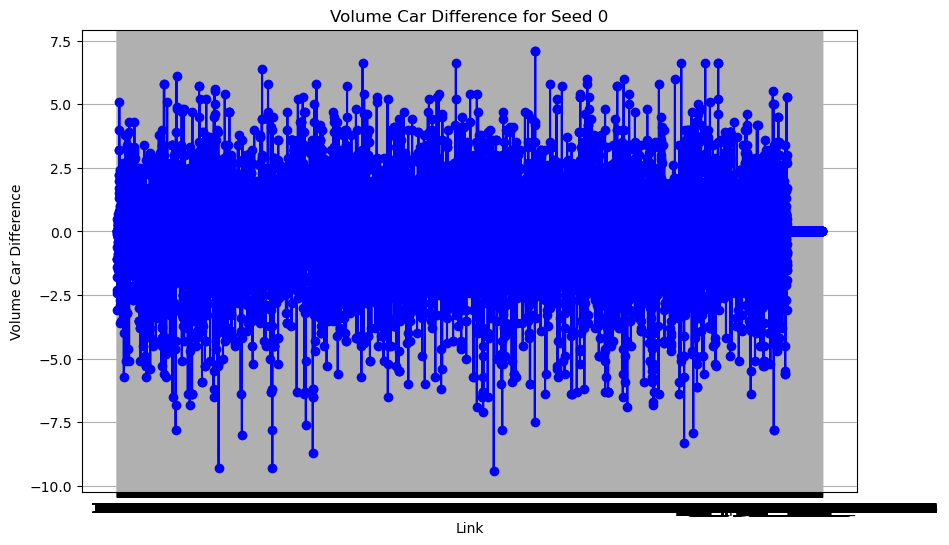

In [9]:
import matplotlib.pyplot as plt

# Plot the difference for the first random seed as an example
seed = '0'
diff_gdf = differences[seed]

plt.figure(figsize=(10, 6))
plt.plot(diff_gdf['link'], diff_gdf['vol_car_diff'], marker='o', linestyle='-', color='b')
plt.xlabel('Link')
plt.ylabel('Volume Car Difference')
plt.title(f'Volume Car Difference for Seed {seed}')
plt.grid(True)
plt.show()